# Climate State Finder

The goal of this notebook is to develop a generalized climate state finder. Based on user selected variable and event definitions, this notebook will search all simulations to find these climate states. Inputs:

* Domain,a custom shapefile
* One variable
* GWL

## Make Selections

Before running this notebook, make the following selections for variables, domain, and GWLs.

1. Select a timescale - this will impact which downscaling methods are available and which variables are availble.

In [1]:
timescale = "monthly" # options are hourly, daily or monthly

2. Select a variable - the code below displays which variables are available based on your timescale options

In [2]:
# import function 
from climakitae.explore.agnostic import (
  show_available_vars
)

In [3]:
# display variables available for this analysis 
# only showing dynamical because statistical has a smaller subset that is in the larger dynamical subset
# only difference is max/min RH is availble in statistical and not in dynamical 
show_available_vars("Dynamical",timescale)

['Air Temperature at 2m',
 'Precipitation (total)',
 'Relative humidity',
 'Dew point temperature',
 'Mean wind speed at 10m',
 'Maximum wind speed at 10m',
 'Surface Pressure',
 'Specific humidity at 2m',
 'Surface skin temperature',
 'Maximum air temperature at 2m',
 'Minimum air temperature at 2m',
 'Instantaneous downwelling longwave flux at bottom',
 'Instantaneous downwelling shortwave flux at bottom',
 'Shortwave flux at the surface',
 'Longwave flux at the surface',
 'Sensible heat flux at the surface',
 'Latent heat flux at the surface',
 'Ground heat flux',
 'Snowfall',
 'Liquid water path',
 'Evaporation',
 'Ice water path',
 'Maximum precipitation']

In [4]:
# make selection from list above
event_variable = "Air Temperature at 2m"

3. Select a baseline and future GWL

In [5]:
# current options 0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 4.0
baseline_gwl = "0.8"
future_gwl = "2.0"

4. Select Spatial Domain - provide a shapefile to clip data to

In [6]:
# edit path below and filename for shapefile to use
shapefile_filename = 'PajaroRiverWatershed.zip'
spatial_domian = "Pajaro" # name will appear in title

5. Select Resolution - select the the model resolution (3km, 9km, 45 km)

In [7]:
resolution = "3 km"

## Import libraries & define functions

In [25]:
import climakitae as ck 
from climakitae.core.data_interface import (
    get_data_options, 
    get_subsetting_options, 
    get_data
)
from climakitae.util.utils import add_dummy_time_to_wl

import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def clip_to_shapefile(da, shapefile):
    """
    Clip a DataArray to the boundaries of a shapefile.

    Parameters:
    - da: xarray DataArray to be clipped
    - shapefile: path to the shapefile

    Returns:
    - Clipped DataArray
    """
    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile)

    # Ensure the DataArray has a CRS set
    #da.rio.write_crs("epsg:2228", inplace=True)

    # Clip the DataArray using the shapefile geometry
    clipped_da = da.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

    return clipped_da

## Pull Data

### Dynamical Downscaling (wrf)

In [13]:
# WRF downscaling
wrf_data =get_data(
        variable = event_variable, 
        downscaling_method = "Dynamical", 
        resolution = resolution, 
        timescale = timescale, 
        # Modify your approach 
        approach = "Warming Level",
        warming_level= [float(baseline_gwl), float(future_gwl)],
    )

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

WARNING FOR WARMING LEVELS APPROACH
-----------------------------------
There may be NaNs in your data for certain simulation/warming level combinations if the warming level is not reached for that particular simulation before the year 2100. 

This does not mean you have missing data, but rather a feature of how the data is combined in retrieval to return a single data object. 

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual warming level and then dropping NaN values.


In [14]:
# rename lat lon
wrf_data=wrf_data.rename({'x': 'longitude','y': 'latitude'})

In [27]:
# add a dummy time variable
wrf_data = add_dummy_time_to_wl(wrf_data)

### Statistical Downscaling (loca2)

In [15]:
# grab correct variable name for loca 2 
loca_variable = [event_variable]
# temperature
if loca_variable[0] == "Air Temperature at 2m":
    loca_variable = ["Maximum air temperature at 2m", "Minimum air temperature at 2m"]
# relative humidity
if loca_variable[0] == "Relative humidity":
    loca_variable = ["Minimum relative humidity", "Maximum relative humidity"]

In [16]:
# statistical - loca2 downscaling xvariable
loca_data = [get_data(
        variable = GETVAR, 
        downscaling_method = "Statistical", 
        resolution = resolution, 
        timescale = timescale, 
        # Modify your approach 
        approach = "Warming Level",
        warming_level= [float(baseline_gwl),float(future_gwl)],
    ) for GETVAR in loca_variable]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

WARNING FOR WARMING LEVELS APPROACH
-----------------------------------
There may be NaNs in your data for certain simulation/warming level combinations if the warming level is not reached for that particular simulation before the year 2100. 

This does not mean you have missing data, but rather a feature of how the data is combined in retrieval to return a single data object. 

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual warming level and then dropping NaN values.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to

In [17]:
# if we need to average 
if loca_data[0] is not None:
    # temperature
    if event_variable == "Air Temperature at 2m":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Air Temperature at 2m"
        
    # relative humidity
    if event_variable == "Relative humidity":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Relative humidity"

In [18]:
# unlist if needed
if type(loca_data) == list:
    loca_data = loca_data[0]

# now merge
# first check if there is valid loca data - requires that both x and y have valid data
if loca_data is None:
    # set to wrf
    loca_data = wrf_data
    # replace with all NaNs
    loca_data = loca_data*np.nan
else:
    loca_data=loca_data.rename({'lon': 'longitude','lat': 'latitude'})

In [26]:
# add a dummy time variable
loca_data = add_dummy_time_to_wl(loca_data)

## Downsize Data

In [19]:
# clip to shapefile
wrf_data = clip_to_shapefile(wrf_data, shapefile_filename)
loca_data = clip_to_shapefile(loca_data, shapefile_filename)

In [20]:
# average across domain (we want single timeseries)
wrf_data = wrf_data.mean(['longitude','latitude'])
loca_data = loca_data.mean(['longitude','latitude'])

## Import Data

In [21]:
loca_data = loca_data.compute()
wrf_data = wrf_data.compute()

## Calculate Anomaly 

### Calculate climatologlical mean of baseline gwl

In [34]:
# calculate monthly mean for each simulation for the baseline gwl
loca_clim_mean = loca_data.sel(warming_level = float(baseline_gwl)).groupby("time.month").median()
wrf_clim_mean = wrf_data.sel(warming_level = float(baseline_gwl)).groupby("time.month").median()

### Calculate anomaly of future gwl to climatologlical mean

In [44]:
# subtract the monthly climatology from the future gwl data to create an anomaly
loca_anom = loca_data.sel(warming_level = float(future_gwl)).groupby("time.month") - loca_clim_mean
wrf_anom = wrf_data.sel(warming_level = float(future_gwl)).groupby("time.month") - wrf_clim_mean

## Prep for Plotting

In [105]:
loca_anom

<xarray.DataArray 'Air Temperature at 2m' (time: 360, simulation: 129)> Size: 372kB
array([[-0.7077179 , -0.2245636 ,  1.69264221, ..., -0.34750366,
         0.20991516,  1.84866333],
       [ 0.78111267, -0.92868042,  2.23588562, ..., -1.43269348,
         2.415802  ,  1.85144043],
       [-0.65687561,  0.45649719,  4.95413208, ..., -0.86309814,
         0.19995117,  3.0214386 ],
       ...,
       [ 4.37077332,  0.67224121,  1.62089539, ...,  0.97576904,
         2.03504944,  3.89468384],
       [ 2.13964844,  4.38482666,  1.145401  , ...,  0.9209137 ,
         2.57084656, -0.1006012 ],
       [ 1.17657471,  5.11216736, -0.23638916, ...,  0.79144287,
         1.67831421,  1.17623901]])
Coordinates:
  * simulation   (simulation) <U48 25kB 'LOCA2_ACCESS-CM2_r1i1p1f1_historical...
    spatial_ref  (time) int64 3kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * time         (time) datetime64[ns] 3kB 2000-01-31 2000-02-29 ... 2029-12-31
    month        (time) int64 3kB 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
Attributes:
    variable_id:           tasmax
    extended_description:  The maximum daily air temperature at 2m above the ...
    units:                 K
    data_type:             Gridded
    resolution:            3 km
    frequency:             monthly
    location_subset:       ['entire domain']
    approach:              Warming Level
    downscaling_method:    Statistical
    warming_level_window:  +/- 15 years from centered year
    institution:           UCSD

In [103]:
# create a data frame to make plotting easier
locaDF = loca_anom.to_dataframe()
wrfDF = wrf_anom.to_dataframe()

In [106]:
locaDF.keys()

Index(['spatial_ref', 'month', 'Air Temperature at 2m'], dtype='object')

In [65]:
# Create a downscaling name
locaDF["downscaling"] = "loca2"
wrfDF["downscaling"] = "wrf"

In [93]:
# combine into one 
finalDF = pd.concat([locaDF, wrfDF],keys=locaDF.keys())

In [97]:
locaDF

spatial_ref  month  \
time       simulation                                                        
2000-01-31 LOCA2_ACCESS-CM2_r1i1p1f1_historical+ssp245            0      1   
           LOCA2_ACCESS-CM2_r2i1p1f1_historical+ssp245            0      1   
           LOCA2_ACCESS-CM2_r3i1p1f1_historical+ssp245            0      1   
           LOCA2_ACCESS-CM2_r1i1p1f1_historical+ssp370            0      1   
           LOCA2_ACCESS-CM2_r2i1p1f1_historical+ssp370            0      1   
...                                                             ...    ...   
2029-12-31 LOCA2_MRI-ESM2-0_r4i1p1f1_historical+ssp370            0     12   
           LOCA2_MRI-ESM2-0_r5i1p1f1_historical+ssp370            0     12   
           LOCA2_MRI-ESM2-0_r1i1p1f1_historical+ssp585            0     12   
           LOCA2_TaiESM1_r1i1p1f1_historical+ssp245               0     12   
           LOCA2_TaiESM1_r1i1p1f1_historical+ssp370               0     12   

                                                        Air Temperature at 2m  \
time       simulation                                                           
2000-01-31 LOCA2_ACCESS-CM2_r1i1p1f1_historical+ssp245              -0.707718   
           LOCA2_ACCESS-CM2_r2i1p1f1_historical+ssp245              -0.224564   
           LOCA2_ACCESS-CM2_r3i1p1f1_historical+ssp245               1.692642   
           LOCA2_ACCESS-CM2_r1i1p1f1_historical+ssp370              -1.199570   
           LOCA2_ACCESS-CM2_r2i1p1f1_historical+ssp370               0.668564   
...                                                                       ...   
2029-12-31 LOCA2_MRI-ESM2-0_r4i1p1f1_historical+ssp370               1.487259   
           LOCA2_MRI-ESM2-0_r5i1p1f1_historical+ssp370              -0.207565   
           LOCA2_MRI-ESM2-0_r1i1p1f1_historical+ssp585               0.791443   
           LOCA2_TaiESM1_r1i1p1f1_historical+ssp245                  1.678314   
           LOCA2_TaiESM1_r1i1p1f1_historical+ssp370                  1.176239   

                                                       downscaling  
time       simulation                                               
2000-01-31 LOCA2_ACCESS-CM2_r1i1p1f1_historical+ssp245       loca2  
           LOCA2_ACCESS-CM2_r2i1p1f1_historical+ssp245       loca2  
           LOCA2_ACCESS-CM2_r3i1p1f1_historical+ssp245       loca2  
           LOCA2_ACCESS-CM2_r1i1p1f1_historical+ssp370       loca2  
           LOCA2_ACCESS-CM2_r2i1p1f1_historical+ssp370       loca2  
...                                                            ...  
2029-12-31 LOCA2_MRI-ESM2-0_r4i1p1f1_historical+ssp370       loca2  
           LOCA2_MRI-ESM2-0_r5i1p1f1_historical+ssp370       loca2  
           LOCA2_MRI-ESM2-0_r1i1p1f1_historical+ssp585       loca2  
           LOCA2_TaiESM1_r1i1p1f1_historical+ssp245          loca2  
           LOCA2_TaiESM1_r1i1p1f1_historical+ssp370          loca2  

[46440 rows x 4 columns]

## Plot Yay!

In [83]:
finalDF.keys()

Index(['spatial_ref', 'month', 'Air Temperature at 2m', 'downscaling',
       'Lambert_Conformal'],
      dtype='object')

In [77]:
# Initialize FacetGrid
g = sns.FacetGrid(finalDF, row="simulation")

KeyError: 'simulation'

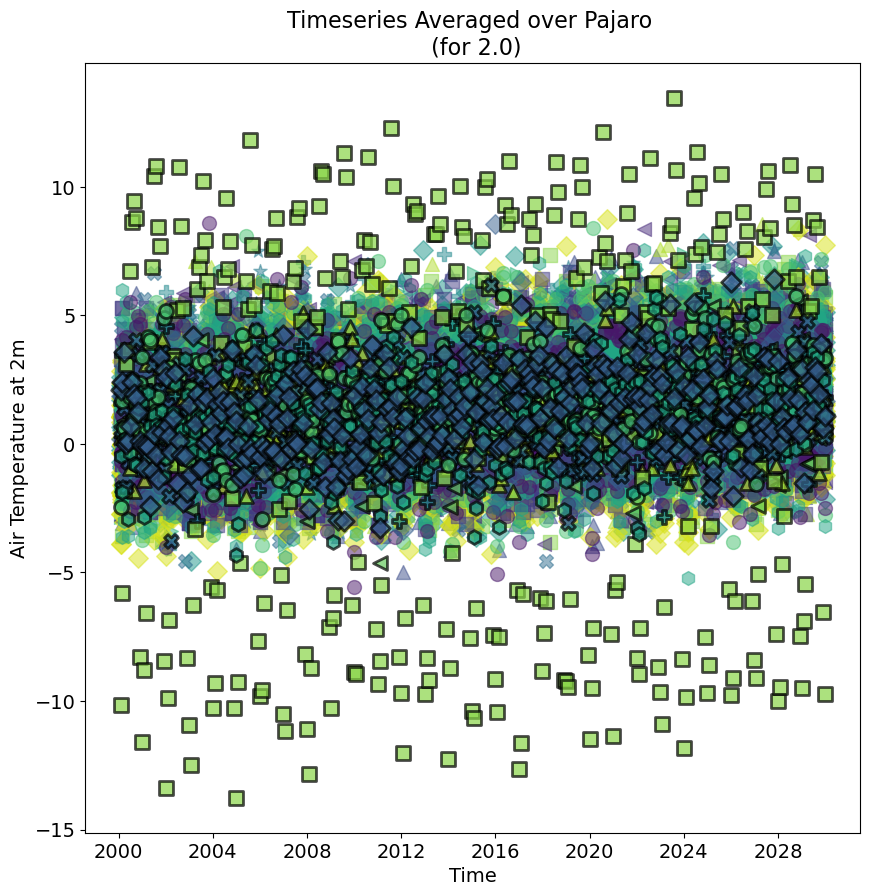

In [52]:
# create the scatterplot
# plot setup
figure = plt.figure(figsize=(10, 10))
ax = figure.add_subplot(111)
ax.set_title(f"Timeseries Averaged over {spatial_domian} \n (for {future_gwl})", fontsize=16)
ax.set_xlabel(f"Time")
ax.set_ylabel(f"{event_variable}")

for i, loca_sim in enumerate(loca_data.simulation.values):
    model = loca_sim.split("_")[1]
    color = model_colors[model]
    marker = model_markers[model]
    # rotate through markers
    ax.scatter(loca_anom["time"], loca_anom.sel(simulation=loca_sim),color = color, label=None, marker=marker, s=100, alpha=0.5)
    
for i, wrf_sim in enumerate(wrf_data.simulation.values):
    model = wrf_sim.split("_")[1]
    color = model_colors[model]
    marker = model_markers[model]
    ax.scatter(wrf_anom["time"], wrf_anom.sel(simulation=wrf_sim), color = color, label=None, linewidths=2, edgecolor='black', marker=marker, s=100, alpha=0.7)
